<a href="https://colab.research.google.com/github/SandumiJay/LNN-for-Wildfire/blob/main/multi_kernal_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Funtionalities**

In [ ]:
import glob
import json
import logging
import os
import tempfile
import time
from typing import Text, Dict, Any, Tuple, Optional

import tensorflow as tf
from tensorflow.compat.v2 import keras

from typing import Text
import tensorflow as tfes
from typing import Sequence, Optional

import re
from typing import Dict, List, Optional, Text, Tuple, Callable

import matplotlib.pyplot as plt
from matplotlib import colors

import tensorflow as tf
import numpy as np

from tqdm import tqdm
from tensorflow.keras.layers import *
from tensorflow.keras import models, layers, Model
from tensorflow.keras import backend as K
from tensorflow.python.keras.utils.losses_utils import reduce_weighted_loss
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam

import os
from sklearn.metrics import accuracy_score, classification_report
from PIL import Image
from skimage.transform import resize
import h5py
import time
import immutabledict

import random

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)



In [ ]:
def save_hparams(hparams, path, indent=None, sort_keys=False):
    """Saves hyperparameters to a JSON file."""
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path, 'w') as f:
        json.dump(hparams, f, indent=indent, sort_keys=sort_keys)

In [ ]:
import os
import tempfile
import shutil
import tensorflow as tf

def save_keras_model(model, path):
    """Saves a Keras model to the specified path."""
    os.makedirs(os.path.dirname(path), exist_ok=True)
    # Add .keras extension to the filepath
    path = path + ".keras" if not (path.endswith(".keras") or path.endswith(".h5")) else path
    with tempfile.TemporaryDirectory() as temp_dir:
        temp_path = os.path.join(temp_dir, 'model.keras') # Create a temporary file with .keras extension
        model.save(temp_path) # Save to the temporary file
        if os.path.exists(path):
            shutil.rmtree(path)  # Remove existing directory if it exists
        shutil.copytree(temp_dir, path, dirs_exist_ok=True) # Copy the temporary directory to the destination


In [ ]:
def save_keras_model_as_h5(model, path):
    """Saves a Keras model to the specified path in HDF5 format."""
    os.makedirs(os.path.dirname(path), exist_ok=True)
    # Add .h5 extension to the filepath
    path = path + ".h5" if not (path.endswith(".keras") or path.endswith(".h5")) else path
    model.save(path, save_format='h5')


In [ ]:
def save_dict_to_json(dictionary, file_path):
    """Saves a dictionary to a JSON file."""
    with open(file_path, 'w') as f:
        json.dump(dictionary, f, indent=4)

In [ ]:
class BestModelExporter(tf.keras.callbacks.Callback):
    """Saves the best model based on specified metric (min or max)."""

    def __init__(self, metric_key, mode, output_dir, use_h5=False):
        super().__init__()
        if mode not in ['min', 'max']:
            raise ValueError("mode must be 'min' or 'max'")
        self.metric_key = metric_key
        self.output_dir = output_dir
        self.mode = mode
        self.best = None
        self.use_h5 = use_h5

    def on_train_begin(self, logs=None):
        # Check if output_dir exists and create if not
        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)

        # Instead of reading metrics from a file, initialize best to a default value
        if self.mode == 'min':
            self.best = float('inf')  # Initialize with a large value for minimization
        else:
            self.best = float('-inf') # Initialize with a small value for maximization


    def on_epoch_end(self, epoch, logs=None):
        """
        Called at the end of each epoch. Checks if the current metric value is better than the best
        seen so far and saves the model if it is.

        Args:
            epoch (int): The current epoch number.
            logs (dict): Dictionary of logs.
        """
        current_metric = logs.get(self.metric_key)

        if current_metric is not None:  # Check if metric is available
            if (self.mode == 'min' and current_metric < self.best) or \
               (self.mode == 'max' and current_metric > self.best):

                self.best = current_metric
                # Save the model
                self.model.save(os.path.join(self.output_dir, f'best_model.h5'))
                logging.info(f"Saved best model with {self.metric_key}: {self.best} at epoch {epoch + 1}")


In [ ]:
class BestModelExporterLNN(tf.keras.callbacks.Callback):
    """Saves the best model based on specified metric (min or max)."""

    def __init__(self, metric_key, mode, output_dir, use_h5=False):
        super().__init__()
        if mode not in ['min', 'max']:
            raise ValueError("mode must be 'min' or 'max'")
        self.metric_key = metric_key
        self.output_dir = output_dir
        self.mode = mode
        self.best = None
        self.use_h5 = use_h5

    def on_train_begin(self, logs=None):
        # Check if output_dir exists and create if not
        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)

        # Instead of reading metrics from a file, initialize best to a default value
        if self.mode == 'min':
            self.best = float('inf')  # Initialize with a large value for minimization
        else:
            self.best = float('-inf') # Initialize with a small value for maximization


    def on_epoch_end(self, epoch, logs=None):
        """
        Called at the end of each epoch. Checks if the current metric value is better than the best
        seen so far and saves the model if it is.

        Args:
            epoch (int): The current epoch number.
            logs (dict): Dictionary of logs.
        """
        current_metric = logs.get(self.metric_key)

        if current_metric is not None:  # Check if metric is available
            if (self.mode == 'min' and current_metric < self.best) or \
               (self.mode == 'max' and current_metric > self.best):

                self.best = current_metric
                # Save the model
                self.model.save(os.path.join(self.output_dir, f'best_model_lnn.h5'))
                logging.info(f"Saved best model with {self.metric_key}: {self.best} at epoch {epoch + 1}")


In [ ]:
class AUCWithMaskedClass(tf.keras.metrics.AUC):
  """Computes AUC while ignoring class with id equal to `-1`.

  Assumes binary `{0, 1}` classes with a masked `{-1}` class.
  """

  def __init__(self, with_logits = False, **kwargs):
    super(AUCWithMaskedClass, self).__init__(**kwargs)
    self.with_logits = with_logits

  @tf.autograph.experimental.do_not_convert
  def update_state(self,
                   y_true,
                   y_pred,
                   sample_weight = None):
    """Accumulates metric statistics.

    `y_true` and `y_pred` should have the same shape.

    Args:
      y_true: Ground truth values.
      y_pred: Predicted values.
      sample_weight: Input value is ignored. Parameter present to match
        signature with parent class where mask `{-1}` is the sample weight.
    Returns: `None`
    """
    if self.with_logits:
      y_pred = tf.math.sigmoid(y_pred)
    mask = tf.cast(tf.not_equal(y_true, -1), tf.float32)
    super(AUCWithMaskedClass, self).update_state(
        y_true, y_pred, sample_weight=mask)

In [ ]:
class PrecisionWithMaskedClass(tf.keras.metrics.Precision):
  """Computes precision while ignoring class with id equal to `-1`.

  Assumes binary `{0, 1}` classes with a masked `{-1}` class.
  """

  def __init__(self, with_logits = False, **kwargs):
    super(PrecisionWithMaskedClass, self).__init__(**kwargs)
    self.with_logits = with_logits

  @tf.autograph.experimental.do_not_convert
  def update_state(self,
                   y_true,
                   y_pred,
                   sample_weight = None):
    """Accumulates metric statistics.

    `y_true` and `y_pred` should have the same shape.

    Args:
      y_true: Ground truth values.
      y_pred: Predicted values.
      sample_weight: Input value is ignored. Parameter present to match
        signature with parent class where mask `{-1}` is the sample weight.
    Returns: `None`
    """
    if self.with_logits:
      y_pred = tf.math.sigmoid(y_pred)
    mask = tf.cast(tf.not_equal(y_true, -1), tf.float32)
    super(PrecisionWithMaskedClass, self).update_state(
        y_true, y_pred, sample_weight=mask)


In [ ]:
class RecallWithMaskedClass(tf.keras.metrics.Recall):
  """Computes recall while ignoring class with id equal to `-1`.

  Assumes binary `{0, 1}` classes with a masked `{-1}` class.
  """

  def __init__(self, with_logits = False, **kwargs):
    super(RecallWithMaskedClass, self).__init__(**kwargs)
    self.with_logits = with_logits

  @tf.autograph.experimental.do_not_convert
  def update_state(self,
                   y_true,
                   y_pred,
                   sample_weight = None):
    """Accumulates metric statistics.

    `y_true` and `y_pred` should have the same shape.

    Args:
      y_true: Ground truth values.
      y_pred: Predicted values.
      sample_weight: Input value is ignored. Parameter present to match
        signature with parent class where mask `{-1}` is the sample weight.
    Returns: `None`
    """
    if self.with_logits:
      y_pred = tf.math.sigmoid(y_pred)
    mask = tf.cast(tf.not_equal(y_true, -1), tf.float32)
    super(RecallWithMaskedClass, self).update_state(
        y_true, y_pred, sample_weight=mask)

# **Data Loading**

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#install required libraries
!pip install -r '/content/drive/MyDrive/requirements.txt'

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 67.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 98.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 49.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 71.7 MB/s eta 0:00:00
  Created wheel for httplib2shim: filename=httplib2shim-0.0.3-py2.py3-none-any.whl size=18041 sha256=7e8523f278831043d8d1c6267bc90b33323880f6d5996eba88a87697887dd50a
  Stored in directory: /root/.cache/pip/wheels/88/e5/dd/0096092515d7a3711c1bbc6c2ea1933a1fe1a62da93a6072a0
Successfully built httplib2shim
  Attempting uninstall: w

In [ ]:
train_file_pattern = '/content/drive/MyDrive/wildfirex_datset/train_dataset/next_day_wildfire_spread_train*'
val_file_pattern = '/content/drive/MyDrive/wildfirex_datset/eval_dataset/next_day_wildfire_spread_eval*'
test_file_pattern = '/content/drive/MyDrive/wildfirex_datset/test_dataset/next_day_wildfire_spread_test*'

In [ ]:
TITLES = [
  'Elevation',
  'Wind\ndirection',
  'Wind\nvelocity',
  'Min\ntemp',
  'Max\ntemp',
  'Humidity',
  'Precip',
  'Drought',
  'Vegetation',
  'Population\ndensity',
  'Energy\nrelease\ncomponent',
  'Previous\nfire\nmask',
  'Fire\nmask'
]

In [ ]:
# Constants for the data reader

INPUT_FEATURES = ['elevation', 'th', 'vs',  'tmmn', 'tmmx', 'sph',
                  'pr', 'pdsi', 'NDVI', 'population', 'erc', 'PrevFireMask']

OUTPUT_FEATURES = ['FireMask']

# Data statistics
# For each variable, the statistics are ordered in the form:
# (min_clip, max_clip, mean, std)
# I recalculated the statistics based on the training set only (uncropped)
DATA_STATS = {
    # 0.1 percentile, 99.9 percentile
    # Elevation
    'elevation' : (0.0, 3536.0, 896.5714, 842.6101),
    # Drought index - this claimed to be pressure, but it's Palmer Drought Severity Index
    # https://en.wikipedia.org/wiki/Palmer_drought_index
    # 0.1 percentile, 99.9 percentile
    'pdsi' : (-6.0559, 6.7432, -0.7729, 2.4407),
    # Normalized Difference Vegetation Index https://gisgeography.com/ndvi-normalized-difference-vegetation-index/
    'NDVI' : (-3826.0, 9282.0, 5350.6865, 2185.2192),
    # Precipitation in mm.
    # Negative values make no sense, so min is set to 0.
    # 0., 99.9 percentile
    'pr': (0.0, 19.2422, 0.3234289, 1.5336641),
    # Specific humidity ranges from 0 to 100%.
    'sph': (0., 1., 0.0065263123, 0.003735537), #max changed to 1
    # Wind direction - degrees clockwise from north.
    # Thus min set to 0 and max set to 360.
    'th' : (0.0, 360.0, 146.6468, 3435.0725),
    # Min/max temperature in Kelvin.
    # -20 degree C, 99.9 percentile
    'tmmn' : (253.15, 299.6313, 281.85196, 18.4972), #min changed
    # -20 degree C, 99.9 percentile
    'tmmx' : (253.15, 317.3869, 297.71643, 19.4581), #min changed
    # Wind speed.
    # Negative values do not make sense, given there is a wind direction.
    # 0., 99.9 percentile
    'vs' : (0.0, 9.7368, 3.6278, 1.3092),
    # NFDRS fire danger index energy release component expressed in BTU's per
    # square foot.
    # Negative values do not make sense. Thus min set to zero.
    # 0., 99.9 percentile
    'erc' : (0.0, 109.9254, 53.4690, 25.0980),
    # Population
    # min, 99.9 percentile
    'population' : (0.0, 2935.7548828125, 30.4603, 214.20015),
    # We don't want to normalize the FireMasks.
    'PrevFireMask': (-1., 1., 0., 1.),
    'FireMask': (-1., 1., 0., 1.)
}

In [ ]:
"""Library of common functions used in deep learning neural networks.
"""
def random_crop_input_and_output_images(
    input_img: tf.Tensor,
    output_img: tf.Tensor,
    sample_size: int,
    num_in_channels: int,
    num_out_channels: int,
) -> Tuple[tf.Tensor, tf.Tensor]:
  """Randomly axis-align crop input and output image tensors.

  Args:
    input_img: Tensor with dimensions HWC.
    output_img: Tensor with dimensions HWC.
    sample_size: Side length (square) to crop to.
    num_in_channels: Number of channels in `input_img`.
    num_out_channels: Number of channels in `output_img`.
  Returns:
    input_img: Tensor with dimensions HWC.
    output_img: Tensor with dimensions HWC.
  """
  combined = tf.concat([input_img, output_img], axis=2)
  combined = tf.image.random_crop(
      combined,
      [sample_size, sample_size, num_in_channels + num_out_channels])
  input_img = combined[:, :, 0:num_in_channels]
  output_img = combined[:, :, -num_out_channels:]
  return input_img, output_img


def center_crop_input_and_output_images(
    input_img: tf.Tensor,
    output_img: tf.Tensor,
    sample_size: int,
) -> Tuple[tf.Tensor, tf.Tensor]:
  """Calls `tf.image.central_crop` on input and output image tensors.

  Args:
    input_img: Tensor with dimensions HWC.
    output_img: Tensor with dimensions HWC.
    sample_size: Side length (square) to crop to.
  Returns:
    input_img: Tensor with dimensions HWC.
    output_img: Tensor with dimensions HWC.
  """
  central_fraction = sample_size / input_img.shape[0]
  input_img = tf.image.central_crop(input_img, central_fraction)
  output_img = tf.image.central_crop(output_img, central_fraction)
  return input_img, output_img


In [ ]:
"""Dataset reader for Earth Engine data."""

def _get_base_key(key: Text) -> Text:
  """Extracts the base key from the provided key.

  Earth Engine exports TFRecords containing each data variable with its
  corresponding variable name. In the case of time sequences, the name of the
  data variable is of the form 'variable_1', 'variable_2', ..., 'variable_n',
  where 'variable' is the name of the variable, and n the number of elements
  in the time sequence. Extracting the base key ensures that each step of the
  time sequence goes through the same normalization steps.
  The base key obeys the following naming pattern: '[a-zA-Z]+'
  For instance, for an input key 'variable_1', this function returns 'variable'.
  For an input key 'variable', this function simply returns 'variable'.

  Args:
    key: Input key.

  Returns:
    The corresponding base key.

  Raises:
    ValueError when `key` does not match the expected pattern.
  """
  match = re.match(r'([a-zA-Z]+)', key)
  if match:
    return match.group(1)
  raise ValueError(f'The provided key does not match the expected pattern: {key}')


def _clip_and_rescale(inputs: tf.Tensor, key: Text) -> tf.Tensor:
  """Clips and rescales inputs with the stats corresponding to `key`.

  Args:
    inputs: Inputs to clip and rescale.
    key: Key describing the inputs.

  Returns:
    Clipped and rescaled input.

  Raises:
    ValueError if there are no data statistics available for `key`.
  """
  base_key = _get_base_key(key)
  if base_key not in DATA_STATS:
    raise ValueError(
        'No data statistics available for the requested key: {}.'.format(key))
  min_val, max_val, _, _ = DATA_STATS[base_key]
  inputs = tf.clip_by_value(inputs, min_val, max_val)
  return tf.math.divide_no_nan((inputs - min_val), (max_val - min_val))


def _clip_and_normalize(inputs: tf.Tensor, key: Text) -> tf.Tensor:
  """Clips and normalizes inputs with the stats corresponding to `key`.

  Args:
    inputs: Inputs to clip and normalize.
    key: Key describing the inputs.

  Returns:
    Clipped and normalized input.

  Raises:
    ValueError if there are no data statistics available for `key`.
  """
  base_key = _get_base_key(key)
  if base_key not in DATA_STATS:
    raise ValueError(
        'No data statistics available for the requested key: {}.'.format(key))
  min_val, max_val, mean, std = DATA_STATS[base_key]
  inputs = tf.clip_by_value(inputs, min_val, max_val)
  inputs = inputs - mean
  return tf.math.divide_no_nan(inputs, std)

def _get_features_dict(
    sample_size: int,
    features: List[Text],
) -> Dict[Text, tf.io.FixedLenFeature]:
  """Creates a features dictionary for TensorFlow IO.

  Args:
    sample_size: Size of the input tiles (square).
    features: List of feature names.

  Returns:
    A features dictionary for TensorFlow IO.
  """
  sample_shape = [sample_size, sample_size]
  features = set(features)
  columns = [
      tf.io.FixedLenFeature(shape=sample_shape, dtype=tf.float32)
      for _ in features
  ]
  return dict(zip(features, columns))


def _parse_fn(
    example_proto: tf.train.Example, data_size: int, sample_size: int,
    num_in_channels: int, clip_and_normalize: bool,
    clip_and_rescale: bool, random_crop: bool, center_crop: bool,
) -> Tuple[tf.Tensor, tf.Tensor]:
  """Reads a serialized example.

  Args:
    example_proto: A TensorFlow example protobuf.
    data_size: Size of tiles (square) as read from input files.
    sample_size: Size the tiles (square) when input into the model.
    num_in_channels: Number of input channels.
    clip_and_normalize: True if the data should be clipped and normalized.
    clip_and_rescale: True if the data should be clipped and rescaled.
    random_crop: True if the data should be randomly cropped.
    center_crop: True if the data should be cropped in the center.

  Returns:
    (input_img, output_img) tuple of inputs and outputs to the ML model.
  """
  if (random_crop and center_crop):
    raise ValueError('Cannot have both random_crop and center_crop be True')
  input_features, output_features = INPUT_FEATURES, OUTPUT_FEATURES
  feature_names = input_features + output_features
  features_dict = _get_features_dict(data_size, feature_names)
  features = tf.io.parse_single_example(example_proto, features_dict)

  if clip_and_normalize:
    inputs_list = [
        _clip_and_normalize(features.get(key), key) for key in input_features
    ]
  elif clip_and_rescale:
    inputs_list = [
        _clip_and_rescale(features.get(key), key) for key in input_features
    ]
  else:
    inputs_list = [features.get(key) for key in input_features]

  inputs_stacked = tf.stack(inputs_list, axis=0)
  input_img = tf.transpose(inputs_stacked, [1, 2, 0])

  outputs_list = [features.get(key) for key in output_features]
  assert outputs_list, 'outputs_list should not be empty'
  outputs_stacked = tf.stack(outputs_list, axis=0)

  outputs_stacked_shape = outputs_stacked.get_shape().as_list()
  assert len(outputs_stacked.shape) == 3, ('outputs_stacked should be rank 3'
                                            'but dimensions of outputs_stacked'
                                            f' are {outputs_stacked_shape}')
  output_img = tf.transpose(outputs_stacked, [1, 2, 0])

  if random_crop:
    input_img, output_img = random_crop_input_and_output_images(
        input_img, output_img, sample_size, num_in_channels, 1)
  if center_crop:
    input_img, output_img = center_crop_input_and_output_images(
        input_img, output_img, sample_size)
  return input_img, output_img


def get_dataset(file_pattern: Text, data_size: int, sample_size: int,
                batch_size: int, num_in_channels: int, compression_type: Text,
                clip_and_normalize: bool, clip_and_rescale: bool,
                random_crop: bool, center_crop: bool) -> tf.data.Dataset:
  """Gets the dataset from the file pattern.

  Args:
    file_pattern: Input file pattern.
    data_size: Size of tiles (square) as read from input files.
    sample_size: Size the tiles (square) when input into the model.
    batch_size: Batch size.
    num_in_channels: Number of input channels.
    compression_type: Type of compression used for the input files.
    clip_and_normalize: True if the data should be clipped and normalized, False
      otherwise.
    clip_and_rescale: True if the data should be clipped and rescaled, False
      otherwise.
    random_crop: True if the data should be randomly cropped.
    center_crop: True if the data shoulde be cropped in the center.

  Returns:
    A TensorFlow dataset loaded from the input file pattern, with features
    described in the constants, and with the shapes determined from the input
    parameters to this function.
  """
  if (clip_and_normalize and clip_and_rescale):
    raise ValueError('Cannot have both normalize and rescale.')
  dataset = tf.data.Dataset.list_files(file_pattern)
  dataset = dataset.interleave(
      lambda x: tf.data.TFRecordDataset(x, compression_type=compression_type),
      num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  dataset = dataset.map(
      lambda x: _parse_fn(  # pylint: disable=g-long-lambda
          x, data_size, sample_size, num_in_channels, clip_and_normalize,
          clip_and_rescale, random_crop, center_crop),
      num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return dataset

In [ ]:
def get_metrics(precs, recs):
  f1s = np.nan_to_num(2*np.nan_to_num(precs)*recs/(np.nan_to_num(precs) + recs))
  return precs[np.argmax(f1s)], recs[np.argmax(f1s)]

In [ ]:
BATCH_SIZE=32
train_dataset = get_dataset(
      train_file_pattern,
      data_size=64,
      sample_size=32,
      batch_size=BATCH_SIZE,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=True,
      clip_and_rescale=False,
      random_crop=True,
      center_crop=False)


In [ ]:
val_dataset = get_dataset(
      val_file_pattern,
      data_size=64,
      sample_size=32,
      batch_size=32,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=True,
      clip_and_rescale=False,
      random_crop=True,
      center_crop=False)

In [ ]:
test_dataset = get_dataset(
      val_file_pattern,
      data_size=64,
      sample_size=32,
      batch_size=32,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=True,
      clip_and_rescale=False,
      random_crop=True,
      center_crop=False)


In [ ]:
train_inputs, train_labels = next(iter(train_dataset))
val_inputs, val_labels = next(iter(val_dataset))
test_inputs, test_labels = next(iter(test_dataset))

In [ ]:
test_inputs, test_labels = next(iter(test_dataset))

In [ ]:
def plot_samples_from_dataset(dataset: tf.data.Dataset, n_rows: int):
    """
    Plot 'n_rows' rows of samples from dataset.

    Args:
        dataset (Dataset): Dataset from which to plot samples.
        n_rows (int): Number of rows to plot.
    """
    global TITLES

    # Get batch
    inputs, labels = None, None
    for elem in dataset:
        inputs, labels = elem
        break

    fig = plt.figure(figsize=(15,6.5))

    # Variables for controllong the color map for the fire masks
    CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
    BOUNDS = [-1, -0.1, 0.001, 1]
    NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)
    # Number of data variables
    n_features = 12
    for i in range(n_rows):
        for j in range(n_features + 1):
            plt.subplot(n_rows, n_features + 1, i * (n_features + 1) + j + 1)
            if i == 0:
                plt.title(TITLES[j], fontsize=13)
            if j < n_features - 1:
                plt.imshow(inputs[i, :, :, j], cmap='viridis')
            if j == n_features - 1:
                plt.imshow(inputs[i, :, :, -1], cmap=CMAP, norm=NORM)
            if j == n_features:
                plt.imshow(labels[i, :, :, 0], cmap=CMAP, norm=NORM)
            plt.axis('off')
    plt.tight_layout()

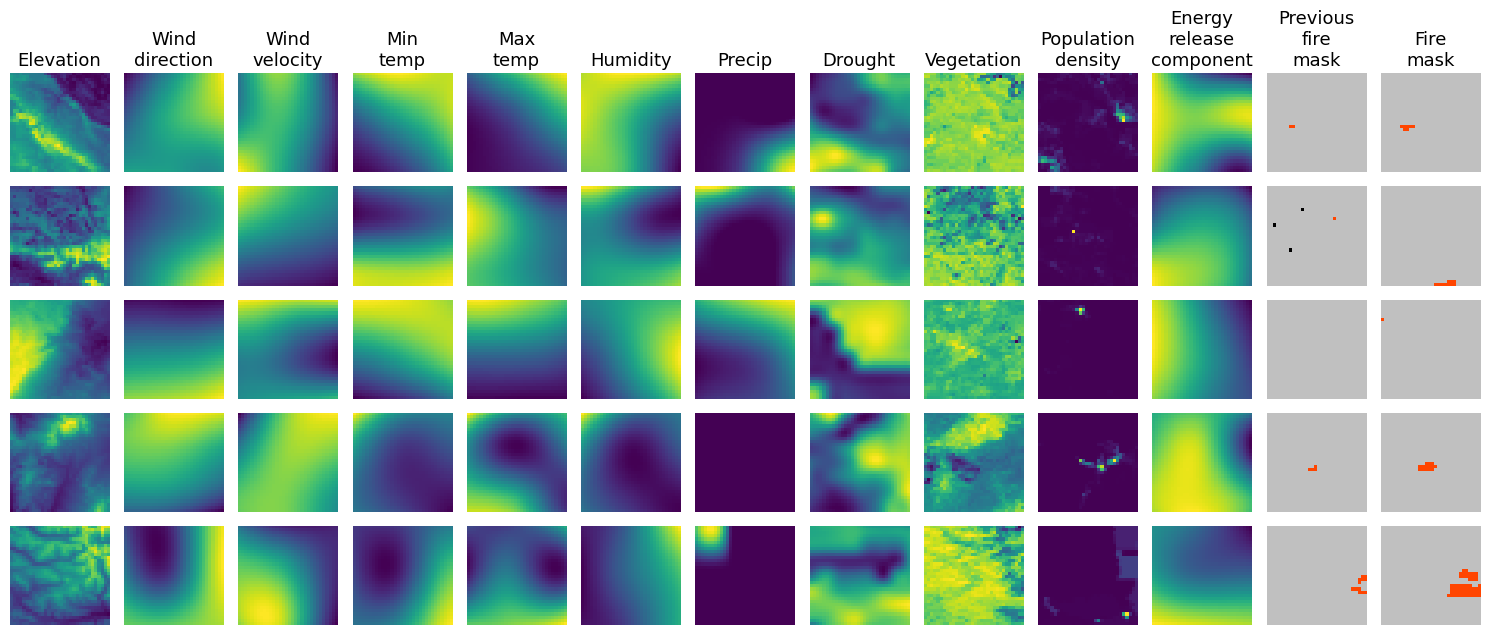

In [ ]:
plot_samples_from_dataset(train_dataset, 5)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.losses import Loss

# Dice coefficient loss function
class DiceLoss(Loss):
    def call(self, y_true, y_pred):
        smooth = 1.0  # To avoid division by zero
        y_true_f = tf.reshape(y_true, [-1])
        y_pred_f = tf.reshape(y_pred, [-1])
        intersection = tf.reduce_sum(y_true_f * y_pred_f)
        dice_score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
        return 1 - dice_score

# Create a callable function for the Dice metric
def dice_metric(y_true, y_pred):
    # Reuse the logic from DiceLoss
    smooth = 1.0
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    dice_score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return dice_score  # Return the Dice score directly (not 1 - score)

In [ ]:

# Multi-kernel CNN model
def multi_kernel_cnn(input_shape=(32, 32, 12)):
    inputs = layers.Input(shape=input_shape)

    # Encoder block
    x = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(inputs)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Applying different kernel sizes
    x1 = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x)
    x2 = layers.Conv2D(64, kernel_size=5, padding='same', activation='relu')(x)
    x3 = layers.Conv2D(64, kernel_size=7, padding='same', activation='relu')(x)

    x = layers.concatenate([x1, x2, x3])
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Further convolution and pooling
    x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Flattening and dense layers
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(1024, activation='sigmoid')(x)

    # Reshaping output to match the desired output size
    outputs = layers.Reshape((32, 32))(x)

    # Creating the model
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Compile and train the model
input_shape = (32, 32, 12)
dice_loss = DiceLoss()
auc=AUCWithMaskedClass()
recall=RecallWithMaskedClass()
precision=PrecisionWithMaskedClass()
model = multi_kernel_cnn(input_shape)
model.summary()

loss_fn = lambda y_true, y_pred: weighted_binary_crossentropy(y_true, y_pred, weight=3)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=loss_fn,
              metrics=['binary_accuracy',auc,recall,precision])


Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 32, 32, 12)]         0         []                            
                                                                                                  
 conv2d_5 (Conv2D)           (None, 32, 32, 32)           3488      ['input_11[0][0]']            
                                                                                                  
 max_pooling2d_3 (MaxPoolin  (None, 16, 16, 32)           0         ['conv2d_5[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_6 (Conv2D)           (None, 16, 16, 64)           18496     ['max_pooling2d_3[0][0]

In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.7 MB/s eta 0:00:00


In [ ]:
def weighted_binary_crossentropy(y_true, y_pred, weight=1.0):
    """
    Custom weighted binary crossentropy.
    You can adjust `weight` to penalize certain classes more heavily.
    """
    bce = tf.keras.losses.BinaryCrossentropy()
    return weight * bce(y_true, y_pred)

In [ ]:
import tensorflow as tf
import keras_tuner as kt
from keras_tuner import RandomSearch


def build_model(hp):
    input_shape = (32, 32, 12)

    # Instantiate the multi-kernel CNN model
    model = multi_kernel_cnn(input_shape)

    # Define hyperparameters for tuning
    learning_rate = hp.Choice('learning_rate', values=[ 1e-3,1e-4,1e-5,0.0005])
    optimizer_choice = hp.Choice('optimizer', values=['adam','rmsprop','adamax'])

    # Configure optimizer based on hyperparameter selection
    if optimizer_choice == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    # Define multiple loss functions and set one for tuning
    loss_choice = hp.Choice('loss_function', values=['dice', 'binary_crossentropy', 'weighted_binary_crossentropy'])
    if loss_choice == 'dice':
        loss_fn = DiceLoss()
    elif loss_choice == 'binary_crossentropy':
        loss_fn = tf.keras.losses.BinaryCrossentropy()
    else:
        # Set a weight for weighted binary crossentropy (customize as needed)
        loss_fn = lambda y_true, y_pred: weighted_binary_crossentropy(y_true, y_pred, weight=3)

    model.compile(optimizer=optimizer,
                  loss=loss_fn,
                  metrics=['binary_accuracy', auc, recall, precision])
    return model

# Set up the tuner with Hyperband search
tuner = RandomSearch(
    build_model,
    objective='val_loss',  # Objective to minimize
    max_trials=20,
    executions_per_trial=1,
    directory='/content/drive/MyDrive/hp',  # Directory for results
    project_name='wildfire_lln_cnn'  # Project name
)

# Run hyperparameter search
tuner.search(train_dataset, epochs=20, validation_data=val_dataset)
# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal learning rate is
{best_hps.get('learning_rate')}, optimizer is {best_hps.get('optimizer')},
and loss function is {best_hps.get('loss_function')}.
""")


Reloading Tuner from /content/drive/MyDrive/hp/wildfire_lln_cnn/tuner0.json

The hyperparameter search is complete. The optimal learning rate is
0.0001, optimizer is adam,
and loss function is weighted_binary_crossentropy.



In [ ]:
import datetime

def get_timestamp_folder_name():
  """Generates a timestamp-based folder name."""
  now = datetime.datetime.now()
  timestamp_str = now.strftime("%Y%m%d_%H%M%S")
  return timestamp_str

timestamp_folder = get_timestamp_folder_name()
print(f"Timestamp folder name: {timestamp_folder}")


# Example of using the timestamp_folder
# Assuming you have a directory where you want to save the model and logs.
model_dir = "/content/drive/MyDrive/models/CNN_multi_kernal" # Or wherever you want to save your model.
model_save_path = os.path.join(model_dir, timestamp_folder) # Create model directory with the timestamp

# Create the model directory
os.makedirs(model_save_path, exist_ok=True) # exist_ok=True prevents error if directory exists

print(f" folder name: {model_save_path}")

Timestamp folder name: 20241107_041611
 folder name: /content/drive/MyDrive/models/CNN_multi_kernal/20241107_041611


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# Train the model
EPOCHS = 1000  # Adjust as needed

best_model_exporter = BestModelExporter(
    metric_key='val_loss',  # Choose the metric to monitor (e.g., 'val_accuracy', 'val_loss')
    mode='min',            # 'min' for minimizing the metric, 'max' for maximizing
    output_dir=model_save_path # Directory to save the best model
)

early_stopper = EarlyStopping(
    monitor='val_loss',  # Metric to monitor (can be 'val_auc', 'val_accuracy', etc.)
    patience=100,         # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Restore model weights from the epoch with the best value of the monitored metric
    mode='min'           # 'min' for minimizing the metric, 'max' for maximizing
)

cnn_model = tuner.hypermodel.build(best_hps)
history = cnn_model.fit(
    train_dataset,
    validation_data=(val_dataset),
    epochs=EPOCHS,
    callbacks=[best_model_exporter,early_stopper] # Pass the instance to callbacks
)


Epoch 1/1000
469/469 [==============================] - 11s 13ms/step - loss: -0.1307 - binary_accuracy: 0.9252 - auc_with_masked_class_9: 0.6308 - recall_with_masked_class_9: 0.0305 - precision_with_masked_class_9: 0.0254 - val_loss: -0.3989 - val_binary_accuracy: 0.9469 - val_auc_with_masked_class_9: 0.6800 - val_recall_with_masked_class_9: 0.0000e+00 - val_precision_with_masked_class_9: 0.0000e+00
Epoch 2/1000


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


469/469 [==============================] - 5s 11ms/step - loss: -0.3770 - binary_accuracy: 0.9533 - auc_with_masked_class_9: 0.6750 - recall_with_masked_class_9: 3.6795e-05 - precision_with_masked_class_9: 0.0415 - val_loss: -0.3195 - val_binary_accuracy: 0.9473 - val_auc_with_masked_class_9: 0.6466 - val_recall_with_masked_class_9: 0.0000e+00 - val_precision_with_masked_class_9: 0.0000e+00
Epoch 3/1000
469/469 [==============================] - 5s 11ms/step - loss: -0.3854 - binary_accuracy: 0.9536 - auc_with_masked_class_9: 0.6810 - recall_with_masked_class_9: 0.0000e+00 - precision_with_masked_class_9: 0.0000e+00 - val_loss: -0.3249 - val_binary_accuracy: 0.9479 - val_auc_with_masked_class_9: 0.6465 - val_recall_with_masked_class_9: 0.0000e+00 - val_precision_with_masked_class_9: 0.0000e+00
Epoch 4/1000
469/469 [==============================] - 5s 11ms/step - loss: -0.4090 - binary_accuracy: 0.9536 - auc_with_masked_class_9: 0.6814 - recall_with_masked_class_9: 0.0000e+00 - precisi

In [ ]:
# Post-processing to generate the future burn map
threshold = 0.8  # This is experimentally set as per your methodology

def post_process(predictions, threshold=0.8):
    # Apply threshold to convert probabilities to binary burn map
    burn_map = (predictions > threshold).astype(np.int32)
    return burn_map
predictions = cnn_model.predict(test_inputs)
burn_map_cnn = post_process(predictions)

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import numpy as np

y_test = test_labels.numpy()

# Get the original shape of burn_map
original_shape = burn_map_cnn.shape

# Print the original shape of burn_map for debugging
print("Original shape of burn_map:", original_shape)

# Reshape burn_map to a 2D array with the number of samples in the first dimension
burn_map_cnn = burn_map_cnn.reshape(burn_map_cnn.shape[0], -1)  # -1 infers the remaining dimensions

# Reshape burn_map to have the same number of samples as y_test
burn_map_cnn = burn_map_cnn.reshape(y_test.shape[0], -1)  # -1 infers the remaining dimensions

# Print the shape of burn_map and y_test for debugging
print("Shape of burn_map after reshape:", burn_map_cnn.shape)
print("Shape of y_test:", y_test.shape)

# Reshape burn_map to match the number of samples in y_test
# burn_map = burn_map.reshape(y_test.shape[0])  # Assuming y_test is 1D

# Flattening predictions and labels for metric calculation
y_true = y_test.flatten()
y_pred = burn_map_cnn.flatten()

# Calculate metrics
precision = precision_score(y_true, y_pred, average='weighted') # or 'micro', 'macro'
recall = recall_score(y_true, y_pred, average='weighted')  # or 'micro', 'macro'
f1 = f1_score(y_true, y_pred, average='weighted')      # or 'micro', 'macro'
overall_accuracy = accuracy_score(y_true, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"Overall Accuracy: {overall_accuracy}")

In [ ]:
# prompt: load best_model_cnn.h5 and do the feature extraction with a regex for flatten_<any nuber>, only one flatten layer

import tensorflow as tf
from tensorflow import keras

# Load the model
# model = keras.models.load_model('/content/cnn_model.h5', compile=False)
model = keras.models.load_model(model_save_path+'/best_model.h5', compile=False)



# Find the flatten layer
flatten_layer = None
for layer in model.layers:
    if re.match(r'flatten_\d+', layer.name):
        flatten_layer = layer
        break
def feature_extraction(inputs):
  if flatten_layer:
      # Create a new model that outputs the flatten layer's activations
      feature_extraction_model = keras.Model(inputs=model.input, outputs=flatten_layer.output)

      # Example usage: extract features from some input data
      # Assuming 'test_inputs' is your input data
      features = feature_extraction_model.predict(inputs)
      print(features.shape)
  else:
      print("No flatten layer found matching the regex.")
  return features

In [ ]:
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

def extract_top_features(train_data, train_labels, num_top_features=64):
    """
    Extract top features from the last convolutional layer using LDA.

    Parameters:
        train_data (np.ndarray): The extracted features from the convolutional layer.
        train_labels (np.ndarray): Corresponding labels for the training data.
        num_top_features (int): Number of top features to extract based on importance.

    Returns:
        np.ndarray: Array of top features after LDA transformation.
    """

    features=feature_extraction(train_data)
    n_samples = features.shape[0]
    reshaped_features = features.reshape(n_samples, -1)

    # Reshape the labels to match the number of feature samples
    train_labels_reshaped = train_labels.numpy().reshape(n_samples, -1)
    train_labels_reshaped = np.clip(train_labels_reshaped, 0, None)

    # Flatten and take the most frequent label for each sample
    train_labels_1d = [np.bincount(x.astype(int)).argmax() for x in train_labels_reshaped]

    # Perform LDA
    lda = LinearDiscriminantAnalysis()
    lda.fit(reshaped_features, train_labels_1d)

    # Get the transformed features (lower dimensionality)
    transformed_features = lda.transform(reshaped_features)

    # Access the importance of features (coefficients)
    feature_importance = np.abs(lda.coef_)

    # Find the indices of the most important features
    top_feature_indices = np.argsort(feature_importance)[::-1][:, :num_top_features]

    # Extract the top features from the original feature map
    top_features = reshaped_features[:, top_feature_indices[0]]

    return top_features




In [ ]:
# Example usage:
train_top_features = extract_top_features(train_inputs,labels,10)
print("Shape of the top features:", train_top_features.shape)

In [ ]:
import numpy as np

# Assuming 'train_top_features' is already calculated as in your code

# Save the top features to a file in Google Drive
np.save('/content/drive/My Drive/top_feature/train_top_features.npy', train_top_features)

print("Top features saved to /content/drive/My Drive/train_top_features.npy")

In [ ]:
val_top_features =extract_top_features(val_inputs,val_labels,10)
print("Shape of the top features:", val_top_features.shape)

In [ ]:
np.save('/content/drive/My Drive/top_feature/val_top_features.npy', val_top_features)

print("Top features saved to /content/drive/My Drive/val_top_features.npy")

In [ ]:
# Example usage:
test_top_features = extract_top_features(test_inputs,test_labels,10)
print("Shape of the top features:", test_top_features.shape)

In [ ]:
np.save('/content/drive/My Drive/top_feature/test_top_features.npy', test_top_features)

print("Top features saved to /content/drive/My Drive/test_top_features.npy")

In [ ]:
!pip install ncps

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 kB 4.5 MB/s eta 0:00:00


In [ ]:
X_train = np.load("/content/drive/My Drive/top_feature/train_top_features.npy")
X_val = np.load("/content/drive/My Drive/top_feature/val_top_features.npy")

NameError: name 'np' is not defined

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from ncps.wirings import AutoNCP
from ncps.tf import CfC
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch

# Define the CFC_CONFIG dictionary for hyperparameter configuration
CFC_CONFIG = {
    "ncp_units": 32,
    "auto_ncp_params": (128, 32),  # hidden_units, output_units for AutoNCP
    "dense_units": 32,
    "activation": 'Softmax',
    "backbone_activation": "gelu",  # Activation function for the backbone
    "backbone_dr": 0.0,  # Dropout rate for the backbone
}

class LNNHyperModel(HyperModel):
    def build(self, hp):
        input_shape = (1, 10)  # Adjust based on your input data shape
        ncp_units = CFC_CONFIG["ncp_units"]  # Use the value from CFC_CONFIG

        # Dynamically set hyperparameters for AutoNCP
        hidden_units = hp.Int('hidden_units', min_value=32, max_value=1024, step=32)
        output_units = hp.Int('output_units', min_value=16, max_value=256, step=16)

        # Hyperparameter tuning for including or excluding AutoNCP
        use_autoncp = hp.Boolean('use_autoncp', default=True)

        # Dynamically set hyperparameters
        dense_units = 1024
        backbone_layers = hp.Int('backbone_layers', min_value=1, max_value=3)
        learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-1, sampling='LOG')

        # Hyperparameter tuning for loss function
        # loss = hp.Choice('loss', values=['binary_crossentropy', 'categorical_crossentropy'])

        model = self.build_LNN_model(input_shape, 32, hidden_units, output_units, backbone_layers, use_autoncp)


        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

        loss_fn = lambda y_true, y_pred: weighted_binary_crossentropy(y_true, y_pred, weight=3)
        auc=AUCWithMaskedClass()
        recall=RecallWithMaskedClass()
        precision=PrecisionWithMaskedClass()


        model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy',recall,auc,precision])

        return model

    def build_LNN_model(self, input_shape, ncp_units, hidden_units, output_units, backbone_layers, use_autoncp):
        input_layer = keras.Input(shape=input_shape)
        x = input_layer  # Assign input_layer to x
        x = layers.Reshape((1, 10))(x)

        if use_autoncp:
            # Use AutoNCP layer
            ncp = CfC(ncp_units, AutoNCP(hidden_units, output_units), return_sequences=True, return_state=False)
            x = ncp(x) # Pass x to the CfC layer
        else:
            ncp = CfC(ncp_units, return_sequences=True, return_state=False)
            x = ncp(x)

        for _ in range(backbone_layers):
            x = layers.Dense(32, activation='gelu')(x)

        x = layers.Reshape((ncp_units,1))(x) # Reshape x
        x = layers.Dense(CFC_CONFIG["dense_units"], activation=CFC_CONFIG["activation"])(x)


        # Check output shape before reshaping
        x = layers.Reshape((32, 32, 1))(x)

        # Use input_layer as the input to the Model
        lnn_model = models.Model(inputs=input_layer, outputs=x)
        return lnn_model

# Instantiate the hypermodel
lnn_hypermodel = LNNHyperModel()

# Define the tuner
tuner = RandomSearch(
    lnn_hypermodel,
    objective='val_loss',
    max_trials=100,
    executions_per_trial=1,
    directory='/content/drive/MyDrive/hp',
    project_name='lnn_tuning'
)

print(X_train.shape)
# Ensure X_train and X_val are defined and properly reshaped
train_data = X_train.reshape(32,1, 10)  # Assuming X_train has shape (32, 32, 10)
val_data = X_val.reshape(32, 1,10)

# Start tuning
tuner.search(train_data, labels, epochs=20, validation_data=(val_data, labels_val))

# Get the best model
best_hp = tuner.get_best_models(num_models=1)[0]

# Print the summary of the best model
best_hp.summary()



ModuleNotFoundError: No module named 'ncps'

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal hyperparameters are:
learning rate: {best_hps.get('learning_rate')}
hidden_units: {best_hps.get('hidden_units')}
output_units: {best_hps.get('output_units')}
use_autoncp: {best_hps.get('use_autoncp')}
backbone_layers: {best_hps.get('backbone_layers')}
""")

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

loss_fn = lambda y_true, y_pred: weighted_binary_crossentropy(y_true, y_pred, weight=3)
# Train the model
EPOCHS = 250  # Adjust as needed

best_model_exporter = BestModelExporterLNN(
    metric_key='val_loss',  # Choose the metric to monitor (e.g., 'val_accuracy', 'val_loss')
    mode='min',            # 'min' for minimizing the metric, 'max' for maximizing
    output_dir='/content/drive/MyDrive/models/lln' # Directory to save the best model
)

early_stopper = EarlyStopping(
    monitor='val_loss',  # Metric to monitor (can be 'val_auc', 'val_accuracy', etc.)
    patience=10,         # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Restore model weights from the epoch with the best value of the monitored metric
    mode='min'           # 'min' for minimizing the metric, 'max' for maximizing
)

lnn_model = tuner.hypermodel.build(tuner.get_best_hyperparameters()[0])

# Reshape train_data to have 32 samples in the first dimension
train_data = X_train.reshape(32,1, 10)  # Assuming X_train has shape (32, 32, 10)
val_data = X_val.reshape(32, 1,10)

# Assuming train_labels and val_labels are correct (shape should be (32,))
history = lnn_model.fit(train_data, train_labels,
                    validation_data=(val_data, val_labels),
                    epochs=10000,
                    callbacks=[best_model_exporter,early_stopper])


In [ ]:
# Post-processing to generate the future burn map
threshold = 0.8  # This is experimentally set as per your methodology

def post_process(predictions, threshold=0.8):
    # Apply threshold to convert probabilities to binary burn map
    burn_map = (predictions > threshold).astype(np.int32)
    return burn_map

# Predict on test data

num_samples = test_top_features.shape[0]  # Get the number of samples

print(test_top_features.shape)

test_data = test_top_features.reshape(num_samples, 1, 10) # Reshape based on num_samples
predictions = lnn_model.predict(test_data)
burn_map = post_process(predictions)

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import numpy as np

y_test = test_labels.numpy()

# Get the original shape of burn_map
original_shape = burn_map.shape

# Print the original shape of burn_map for debugging
print("Original shape of burn_map:", original_shape)

# Reshape burn_map to a 2D array with the number of samples in the first dimension
burn_map = burn_map.reshape(burn_map.shape[0], -1)  # -1 infers the remaining dimensions

# Reshape burn_map to have the same number of samples as y_test
burn_map = burn_map.reshape(y_test.shape[0], -1)  # -1 infers the remaining dimensions

# Print the shape of burn_map and y_test for debugging
print("Shape of burn_map after reshape:", burn_map.shape)
print("Shape of y_test:", y_test.shape)

# Reshape burn_map to match the number of samples in y_test
# burn_map = burn_map.reshape(y_test.shape[0])  # Assuming y_test is 1D

# Flattening predictions and labels for metric calculation
y_true = y_test.flatten()
y_pred = burn_map.flatten()

# Calculate metrics
precision = precision_score(y_true, y_pred, average='weighted') # or 'micro', 'macro'
recall = recall_score(y_true, y_pred, average='weighted')  # or 'micro', 'macro'
f1 = f1_score(y_true, y_pred, average='weighted')      # or 'micro', 'macro'
overall_accuracy = accuracy_score(y_true, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"Overall Accuracy: {overall_accuracy}")

In [ ]:
cnn_model = keras.models.load_model('/content/drive/MyDrive/models/CNN_multi_kernal/20241105_211252/best_model.h5', compile=False)

In [ ]:
# Post-processing to generate the future burn map
threshold = 0.8  # This is experimentally set as per your methodology

def post_process(predictions, threshold=0.8):
    # Apply threshold to convert probabilities to binary burn map
    burn_map = (predictions > threshold).astype(np.int32)
    return burn_map

# Predict on test data

predictions_ = cnn_model.predict(test_inputs)
burn_map_ = post_process(predictions_)

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import numpy as np

# Assuming you have your test data and labels loaded as test_inputs and y_test respectively

# Reshape y_test to match burn_map if necessary
y_test = test_labels.numpy()

# Get the original shape of burn_map
original_shape = burn_map_.shape

# Print the original shape of burn_map for debugging
print("Original shape of burn_map:", original_shape)

# Reshape burn_map to a 2D array with the number of samples in the first dimension
burn_map_ = burn_map_.reshape(burn_map.shape[0], -1)  # -1 infers the remaining dimensions

# Reshape burn_map to have the same number of samples as y_test
burn_map_ = burn_map_.reshape(y_test.shape[0], -1)  # -1 infers the remaining dimensions

# Print the shape of burn_map and y_test for debugging
print("Shape of burn_map after reshape:", burn_map_.shape)
print("Shape of y_test:", y_test.shape)

# Reshape burn_map to match the number of samples in y_test
# burn_map = burn_map.reshape(y_test.shape[0])  # Assuming y_test is 1D

# Flattening predictions and labels for metric calculation
y_true = y_test.flatten()
y_pred = burn_map_.flatten()

# Calculate metrics
precision = precision_score(y_true, y_pred, average='weighted') # or 'micro', 'macro'
recall = recall_score(y_true, y_pred, average='weighted')  # or 'micro', 'macro'
f1 = f1_score(y_true, y_pred, average='weighted')      # or 'micro', 'macro'
overall_accuracy = accuracy_score(y_true, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"Overall Accuracy: {overall_accuracy}")

In [ ]:
Original shape of burn_map: (32, 32, 32, 1)
Shape of burn_map after reshape: (32, 1024)
Shape of y_test: (32, 32, 32, 1)
Precision: 0.7520422859045738
Recall: 0.86383056640625
F1-Score: 0.8040695935517047
Overall Accuracy: 0.86383056640625
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:


import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()









In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Plot training & validation auc values
plt.figure(figsize=(10, 5))
plt.plot(history.history['auc_with_masked_class_2'])
plt.plot(history.history['val_auc_with_masked_class_2'])
plt.title('Model auc')
plt.ylabel('auc')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Plot training & validation recall values
plt.figure(figsize=(10, 5))
plt.plot(history.history['recall_with_masked_class_2'])
plt.plot(history.history['val_recall_with_masked_class_2'])
plt.title('Model recall')
plt.ylabel('recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Plot training & validation precision values
plt.figure(figsize=(10, 5))
plt.plot(history.history['precision_with_masked_class'])
plt.plot(history.history['val_precision_with_masked_class'])
plt.title('Model precision')
plt.ylabel('precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
n_rows = 10
n_features = test_inputs.shape[3]
CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
BOUNDS = [-1, -0.1, 0.001, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)
keys = INPUT_FEATURES

In [ ]:
predictions = lnn_model.predict(test_data)
burn_map = post_process(predictions)

In [ ]:
pred = lnn_model.predict(test_data)
plt.imshow(pred[0], cmap='plasma')

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np

# Assuming burn_map is already calculated

# Assuming you have your test data and labels loaded as test_inputs and y_test respectively
# Example: Assuming your burn_map is a 64x64 image

# Choose a specific image from the burn_map array (e.g., the first image)
image_index = 0  # You can change this to visualize other images
burn_map_image = burn_map[image_index, :, :, 0]  # Select the image and remove the channel dimension

# Display the burn map
plt.imshow(burn_map_image, cmap='plasma', interpolation='nearest')  # Adjust cmap if needed
plt.title('Burn Map')
plt.colorbar()  # Show the color scale
plt.show()

In [ ]:
fig = plt.figure(figsize=(9,20))
n_rows = 8

for i in range(n_rows):
  # fire_index = i + 1000  # This line is causing the error
  fire_index = i  # Change to this to access indices within the bounds of test_inputs
  plt.subplot(n_rows,3, 3*i + 1)
  plt.title("Last fire", fontsize=13)
  plt.imshow(train_inputs[fire_index, :, :, -1], cmap=CMAP, norm=NORM)
  plt.axis('off')
  plt.subplot(n_rows,3, 3*i + 2)
  plt.title("Actual fire", fontsize=13)
  plt.imshow(train_labels[fire_index, :, :, 0], cmap=CMAP, norm=NORM)
  plt.axis('off')
  plt.subplot(n_rows,3, 3*i + 3)
  plt.title("Prediction", fontsize=13)
  plt.imshow(pred[fire_index], cmap='plasma')
  plt.colorbar()
  plt.axis('off')
plt.tight_layout()